In [60]:
!pip install eli5 mne

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.decomposition import PCA
from sklearn import linear_model
from matplotlib_venn import venn3
import warnings
from collections import Counter
import mne
from mne.channels import make_standard_montage
from imblearn.over_sampling import SMOTE
from sklearn.inspection import permutation_importance
import shap
import eli5
from eli5.sklearn import PermutationImportance

In [62]:
#EEG channel names according to 10-20 system
EEG_CHANNELS = [
    'Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T7', 'C3', 'Cz', 'C4', 'T8',
    'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'Oz', 'O2', 'AF3', 'AF4', 'F5', 'F1',
    'F2', 'F6', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 'C1',
    'C2', 'C6', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'P5', 'P1',
    'P2', 'P6', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'FT7', 'FT8', 'TP7', 'TP8',
    'PO9', 'PO10', 'O9', 'Iz', 'O10', 'Fpz', 'AFz'
]

FREQUENCY_BANDS = ['delta', 'theta', 'alpha', 'beta', 'gamma']


In [63]:
def load_data(url):
    data = pd.read_csv(url)
    print(f"Data loaded: {data.shape[0]} samples with {data.shape[1]} features")
    print(f"Column names: {data.columns[:10]}...")

    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]

    class_counts = Counter(y)
    print(f"Class distribution: {class_counts}")

    return X, y, data

In [64]:
def handle_outliers(X, method='iqr'):
    X_clean = X.copy()
    outliers_count = 0

    if method == 'iqr':
        for col in X.columns:
            Q1 = X[col].quantile(0.25)
            Q3 = X[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            outliers = ((X[col] < lower_bound) | (X[col] > upper_bound))
            outliers_count += outliers.sum()

            #replace outliers with median
            X_clean.loc[outliers, col] = X[col].median()

    print(f"Total outliers detected and replaced: {outliers_count}")
    return X_clean

In [65]:
def scale_features(X_train, X_val, X_test):
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_val_scaled, X_test_scaled, scaler

In [66]:
def select_features(X_train, y_train, X_val, X_test, feature_names, k=5):
    print(f"Selecting top {k} features using multiple methods")

    #univariate feature selection
    print("Performing Univariate Feature Selection:")
    selector_ufs = SelectKBest(score_func=f_classif, k=k)
    selector_ufs.fit(X_train, y_train)

    ufs_indices = selector_ufs.get_support(indices=True)
    ufs_features = [feature_names[i] for i in ufs_indices]
    print(f"UFS selected features: {ufs_features}")

    ufs_scores = selector_ufs.scores_
    ufs_pvalues = selector_ufs.pvalues_

    #recursive feature elimination
    print("Performing Recursive Feature Elimination:")
    svc = SVC(kernel='linear')
    selector_rfe = RFE(estimator=svc, n_features_to_select=k, step=1)
    selector_rfe.fit(X_train, y_train)

    rfe_indices = np.where(selector_rfe.support_)[0]
    rfe_features = [feature_names[i] for i in rfe_indices]
    print(f"RFE selected features: {rfe_features}")

    #PCA
    print("Performing Principal Component Analysis:")
    pca = PCA(n_components=k)
    pca.fit(X_train)

    #most influential features in each component
    pca_components = pca.components_
    pca_features = []

    #feature with highest absolute loading
    for component in pca_components:
        most_important_idx = np.abs(component).argmax()
        pca_features.append(feature_names[most_important_idx])

    print(f"PCA identified important features: {pca_features}")

    X_train_ufs = selector_ufs.transform(X_train)
    X_val_ufs = selector_ufs.transform(X_val)
    X_test_ufs = selector_ufs.transform(X_test)

    X_train_rfe = selector_rfe.transform(X_train)
    X_val_rfe = selector_rfe.transform(X_val)
    X_test_rfe = selector_rfe.transform(X_test)

    X_train_pca = pca.transform(X_train)
    X_val_pca = pca.transform(X_val)
    X_test_pca = pca.transform(X_test)

    #visualization of feature overlap between methods
    all_features = set(ufs_features) | set(rfe_features) | set(pca_features)
    print(f"Union of all selected features: {all_features}")

    #return selected features and transformed datasets
    return {
        'ufs': {
            'X_train': X_train_ufs,
            'X_val': X_val_ufs,
            'X_test': X_test_ufs,
            'features': ufs_features,
            'scores': ufs_scores,
            'pvalues': ufs_pvalues
        },
        'rfe': {
            'X_train': X_train_rfe,
            'X_val': X_val_rfe,
            'X_test': X_test_rfe,
            'features': rfe_features,
            'ranking': selector_rfe.ranking_
        },
        'pca': {
            'X_train': X_train_pca,
            'X_val': X_val_pca,
            'X_test': X_test_pca,
            'features': pca_features,
            'explained_variance': pca.explained_variance_ratio_,
            'components': pca.components_
        },
        'all_features': all_features
    }


In [67]:
def visualize_feature_selection(feature_selection_results, feature_names):
    ufs_features = set(feature_selection_results['ufs']['features'])
    rfe_features = set(feature_selection_results['rfe']['features'])
    pca_features = set(feature_selection_results['pca']['features'])

    plt.figure(figsize=(10, 7))
    venn3([ufs_features, rfe_features, pca_features], ('UFS', 'RFE', 'PCA'))
    plt.title('Overlap of Selected Features by Method')
    plt.show()

    plt.figure(figsize=(14, 10))

    if len(feature_names) > 30:  #limit to top 30 by UFS score
        top_indices = np.argsort(feature_selection_results['ufs']['scores'])[-30:]
        subset_features = [feature_names[i] for i in top_indices]
        subset_scores = feature_selection_results['ufs']['scores'][top_indices]
    else:
        subset_features = feature_names
        subset_scores = feature_selection_results['ufs']['scores']

    sns.barplot(x=subset_scores, y=subset_features)
    plt.title('Feature Importance (F-score from UFS)')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 6))
    explained_var = feature_selection_results['pca']['explained_variance']
    plt.bar(range(1, len(explained_var) + 1), explained_var)
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title('PCA Explained Variance')
    plt.xticks(range(1, len(explained_var) + 1))
    plt.show()


In [68]:
def train_models(X_train, y_train, X_val, y_val, feature_selection_method=None):
    models = {}

    #linear regression (using threshold)
    print("Training Linear Regression for classification:")
    lr = linear_model.LinearRegression()
    lr.fit(X_train, y_train)

    #optimal threshold using validation set for LR
    y_val_pred_lr = lr.predict(X_val)
    thresholds = np.linspace(min(y_val_pred_lr), max(y_val_pred_lr), 100)
    best_accuracy = 0
    best_threshold = 0.5

    for threshold in thresholds:
        y_val_binary = (y_val_pred_lr >= threshold).astype(int)
        acc = accuracy_score(y_val, y_val_binary)
        if acc > best_accuracy:
            best_accuracy = acc
            best_threshold = threshold

    print(f"Linear Regression - Best threshold: {best_threshold}, Validation accuracy: {best_accuracy:.4f}")
    models['lr'] = {'model': lr, 'threshold': best_threshold}

    #SVM with hyperparameter tuning
    print("Training SVM with hyperparameter tuning:")
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto', 0.1, 0.01]
    }

    svm = SVC(probability=True)
    grid_svm = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')
    grid_svm.fit(X_train, y_train)

    best_svm = grid_svm.best_estimator_
    print(f"SVM - Best parameters: {grid_svm.best_params_}")
    models['svm'] = {'model': best_svm}

    #KNN with hyperparameter tuning
    print("Training KNN with hyperparameter tuning:")
    param_grid = {
        'n_neighbors': [3, 5, 7, 9, 11, 13],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    }

    knn = KNeighborsClassifier()
    grid_knn = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
    grid_knn.fit(X_train, y_train)

    best_knn = grid_knn.best_estimator_
    print(f"KNN - Best parameters: {grid_knn.best_params_}")
    models['knn'] = {'model': best_knn}

    return models

In [69]:
def evaluate_models(models, X_test, y_test, feature_selection_results=None):
    results = {}

    for model_name, model_info in models.items():
        print(f"\nEvaluating {model_name.upper()} model:")
        model = model_info['model']

        if model_name == 'lr':
            threshold = model_info['threshold']
            y_pred_prob = model.predict(X_test)
            y_pred = (y_pred_prob >= threshold).astype(int)
        else:
            y_pred = model.predict(X_test)
            y_pred_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")

        cm = confusion_matrix(y_test, y_pred)

        results[model_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'confusion_matrix': cm,
            'y_pred': y_pred,
            'y_pred_prob': y_pred_prob
        }

        if y_pred_prob is not None:
            fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
            roc_auc = auc(fpr, tpr)
            results[model_name]['roc'] = {'fpr': fpr, 'tpr': tpr, 'auc': roc_auc}
            print(f"AUC-ROC: {roc_auc:.4f}")

    return results

In [70]:
def visualize_evaluation(evaluation_results):
    model_names = list(evaluation_results.keys())
    metrics = ['accuracy', 'precision', 'recall', 'f1']

    plt.figure(figsize=(12, 8))
    width = 0.2
    x = np.arange(len(model_names))

    for i, metric in enumerate(metrics):
        values = [evaluation_results[model][metric] for model in model_names]
        plt.bar(x + i * width, values, width, label=metric)

    plt.xlabel('Models')
    plt.ylabel('Score')
    plt.title('Performance Metrics Comparison')
    plt.xticks(x + width * 1.5, model_names)
    plt.legend()
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    #confusion matrices
    fig, axes = plt.subplots(1, len(model_names), figsize=(15, 5))
    if len(model_names) == 1:
        axes = [axes]

    for i, model_name in enumerate(model_names):
        cm = evaluation_results[model_name]['confusion_matrix']
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
        axes[i].set_title(f'{model_name.upper()} Confusion Matrix')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

    #ROC curves
    plt.figure(figsize=(10, 8))
    for model_name in model_names:
        if 'roc' in evaluation_results[model_name]:
            roc_data = evaluation_results[model_name]['roc']
            plt.plot(roc_data['fpr'], roc_data['tpr'], label=f'{model_name.upper()} (AUC = {roc_data["auc"]:.4f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [71]:
def analyze_spatial_patterns(X, y, feature_names, class_names=['Class 0', 'Class 1']):
    print("Analyzing spatial patterns in EEG data:")

    channels = []
    bands = []
    values = []

    has_channel_info = any('_' in feat for feat in feature_names)

    if not has_channel_info:
        print("Feature names don't contain enough channel information for spatial analysis")
        return

    for i, feature in enumerate(feature_names):
        if '_' in feature:
            parts = feature.split('_')
            channel = parts[0]
            band = parts[1] if len(parts) > 1 else 'unknown'

            if channel in EEG_CHANNELS:
                channels.append(channel)
                bands.append(band)
                values.append(i)  #store feature index

    if not channels:
        print("No valid channel information found in feature names")
        return

    try:
        info = mne.create_info(channels, sfreq=256, ch_types='eeg')
        montage = make_standard_montage('standard_1020')

        unique_bands = set(bands)

        for band in unique_bands:
            if band == 'unknown':
                continue

            band_indices = [values[i] for i, b in enumerate(bands) if b == band]

            if not band_indices:
                continue

            class_0_avg = np.mean(X[y == 0][:, band_indices], axis=0)
            class_1_avg = np.mean(X[y == 1][:, band_indices], axis=0)
            diff_avg = class_1_avg - class_0_avg

            data_arrays = [
                (class_0_avg, f'{class_names[0]} - {band}'),
                (class_1_avg, f'{class_names[1]} - {band}'),
                (diff_avg, f'Difference - {band}')
            ]

            fig, axes = plt.subplots(1, 3, figsize=(18, 6))

            for i, (data, title) in enumerate(data_arrays):
                band_channels = [channels[values.index(idx)] for idx in band_indices]

                temp_data = np.zeros(len(channels))
                for ch_idx, ch in enumerate(band_channels):
                    if ch in channels:
                        ch_pos = channels.index(ch)
                        temp_data[ch_pos] = data[ch_idx]

                evoked = mne.EvokedArray(temp_data.reshape(1, -1), info)
                evoked.set_montage(montage)

                mne.viz.plot_topomap(evoked.data[0], evoked.info, axes=axes[i], show=False)
                axes[i].set_title(title)

            plt.tight_layout()
            plt.show()

    except Exception as e:
        print(f"Error in MNE spatial analysis: {str(e)}")
        return

In [72]:
def interpret_models(models, X_test, feature_names):
    print("\nInterpreting models with SHAP values:")

    for model_name, model_info in models.items():
        model = model_info['model']

        print(f"\nSHAP analysis for {model_name.upper()}:")

        try:
            explainer = shap.Explainer(model, X_test)
            shap_values = explainer(X_test)

            plt.figure(figsize=(12, 8))
            shap.summary_plot(shap_values, X_test, feature_names=feature_names, show=False)
            plt.title(f'SHAP Summary for {model_name.upper()}')
            plt.tight_layout()
            plt.show()

            plt.figure(figsize=(12, 8))
            shap.plots.bar(shap_values, show=False)
            plt.title(f'SHAP Feature Importance for {model_name.upper()}')
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Error in SHAP analysis for {model_name}: {str(e)}")

            print("Falling back to permutation importance")
            try:
                perm = PermutationImportance(model, random_state=42)
                perm.fit(X_test, perm.predict(X_test))

                perm_importance = pd.DataFrame({
                    'Feature': feature_names,
                    'Importance': perm.feature_importances_
                }).sort_values('Importance', ascending=False)

                plt.figure(figsize=(12, 8))
                sns.barplot(x='Importance', y='Feature', data=perm_importance.head(20))
                plt.title(f'Permutation Importance for {model_name.upper()}')
                plt.tight_layout()
                plt.show()

            except Exception as e2:
                print(f"Error in permutation importance: {str(e2)}")

In [73]:
def augment_data(X_train, y_train):
    print("Performing data augmentation with SMOTE...")

    class_counts = Counter(y_train)
    print(f"Class distribution before augmentation: {class_counts}")

    smote = SMOTE(random_state=42)
    X_train_aug, y_train_aug = smote.fit_resample(X_train, y_train)

    class_counts_aug = Counter(y_train_aug)
    print(f"Class distribution after augmentation: {class_counts_aug}")

    return X_train


In [74]:
def compare_feature_selection_methods(evaluation_by_method):
    print("\n=== Comparison of Feature Selection Methods ===")

    methods = list(evaluation_by_method.keys())
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    models = list(evaluation_by_method[methods[0]].keys())
    comparison_data = []

    for method in methods:
        for model in models:
            row = {'Method': method.upper(), 'Model': model.upper()}
            for metric in metrics:
                row[metric] = evaluation_by_method[method][model][metric]
            comparison_data.append(row)

    df_comparison = pd.DataFrame(comparison_data)

    print("\nPerformance comparison table:")
    print(df_comparison)

    plt.figure(figsize=(15, 10))

    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i+1)

        pivot_data = df_comparison.pivot(index='Model', columns='Method', values=metric)
        pivot_data.plot(kind='bar', ax=plt.gca())

        plt.title(f'{metric.capitalize()} by Feature Selection Method')
        plt.xlabel('Model')
        plt.ylabel(f'{metric.capitalize()} Score')
        plt.ylim(0, 1)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.legend(title='Feature Selection')

    plt.tight_layout()
    plt.show()

In [81]:
def report_top_features(feature_selection_results):
    print("\n=== Top 5 Features by Selection Method ===")
    ufs_features = feature_selection_results['ufs']['features']
    rfe_features = feature_selection_results['rfe']['features']
    pca_features = feature_selection_results['pca']['features']

    print("\nTop 5 UFS Features:")
    for i, feature in enumerate(ufs_features):
        print(f"{i+1}. {feature}")

    print("\nTop 5 RFE Features:")
    for i, feature in enumerate(rfe_features):
        print(f"{i+1}. {feature}")

    print("\nTop 5 PCA Features:")
    for i, feature in enumerate(pca_features):
        print(f"{i+1}. {feature}")

    overlap_all = set(ufs_features) & set(rfe_features) & set(pca_features)
    overlap_ufs_rfe = set(ufs_features) & set(rfe_features)
    overlap_ufs_pca = set(ufs_features) & set(pca_features)
    overlap_rfe_pca = set(rfe_features) & set(pca_features)

In [82]:
def main():
    url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vSC87hYugbdg0_MbAhqVHaGSTk_-tEb_X_1YeXo6qzuz-bKm3Vo3gQd6m4IlZ5CAQMUUxfZrtCgbWYv/pub?output=csv"
    X, y, data = load_data(url)
    feature_names = X.columns

    print("\nData overview:")
    print(f"Total samples: {X.shape[0]}")
    print(f"Total features: {X.shape[1]}")
    print(f"Classes: {np.unique(y)}")
    print(f"Class distribution: {Counter(y)}")

    X_clean = handle_outliers(X)

    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X_clean, y, test_size=0.2, random_state=42, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)
    print(f"\nSplit sizes:")
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")

    X_train_scaled, X_val_scaled, X_test_scaled, scaler = scale_features(X_train, X_val, X_test)

    X_train_eng = X_train_scaled
    X_val_eng = X_val_scaled
    X_test_eng = X_test_scaled
    eng_feature_names = feature_names

    print(f"\nAfter scaling (no additional feature engineering):")
    print(f"Training set shape: {X_train_eng.shape}")
    print(f"Total features: {X_train_eng.shape[1]}")

    X_train_eng, y_train = augment_data(X_train_eng, y_train)

    feature_selection_results = select_features(X_train_eng, y_train, X_val_eng, X_test_eng, eng_feature_names)

    visualize_feature_selection(feature_selection_results, eng_feature_names)

    analyze_spatial_patterns(X_train_eng, y_train, eng_feature_names)

    feature_selection_methods = ['ufs', 'rfe', 'pca']
    evaluation_by_method = {}
    for method in feature_selection_methods:
        print(f"\n=== Training and evaluating models with {method.upper()} feature selection ===")
        X_train_fs = feature_selection_results[method]['X_train']
        X_val_fs = feature_selection_results[method]['X_val']
        X_test_fs = feature_selection_results[method]['X_test']
        fs_feature_names = feature_selection_results[method]['features']

        models = train_models(X_train_fs, y_train, X_val_fs, y_val, method)
        evaluation_results = evaluate_models(models, X_test_fs, y_test)
        evaluation_by_method[method] = evaluation_results

        visualize_evaluation(evaluation_results)
        interpret_models(models, X_test_fs, fs_feature_names)

    compare_feature_selection_methods(evaluation_by_method)
    report_top_features(feature_selection_results)

Loading data from URL...
Data loaded: 40 samples with 322 features
Column names: Index(['Unnamed: 0', 'alpha1', 'alpha2', 'alpha3', 'alpha4', 'alpha5',
       'alpha6', 'alpha7', 'alpha8', 'alpha9'],
      dtype='object')...
Class distribution: Counter({1: 20, 0: 20})

Data overview:
Total samples: 40
Total features: 321
Classes: [0 1]
Class distribution: Counter({1: 20, 0: 20})
Detecting outliers...
Total outliers detected and replaced: 972

Split sizes:
Training set: 24 samples
Validation set: 8 samples
Test set: 8 samples

After scaling (no additional feature engineering):
Training set shape: (24, 321)
Total features: 321
Performing data augmentation with SMOTE...
Class distribution before augmentation: Counter({1: 12, 0: 12})
Class distribution after augmentation: Counter({1: 12, 0: 12})
Selecting top 5 features using multiple methods...
Performing Univariate Feature Selection...
UFS selected features: ['Unnamed: 0', 'beta4', 'delta21', 'gamma16', 'gamma21']
Performing Recursive Fe

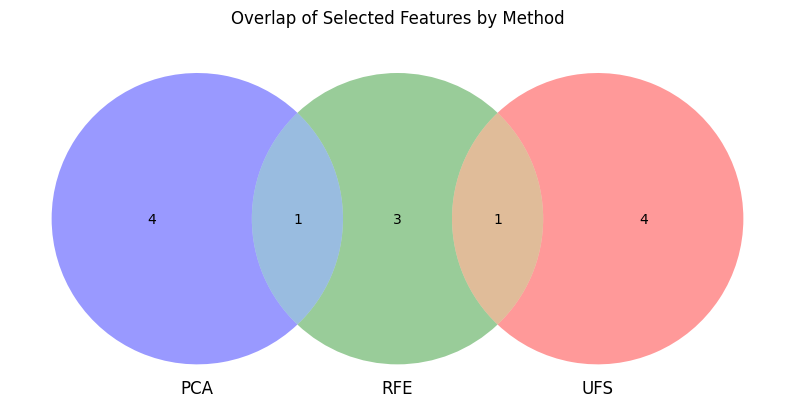

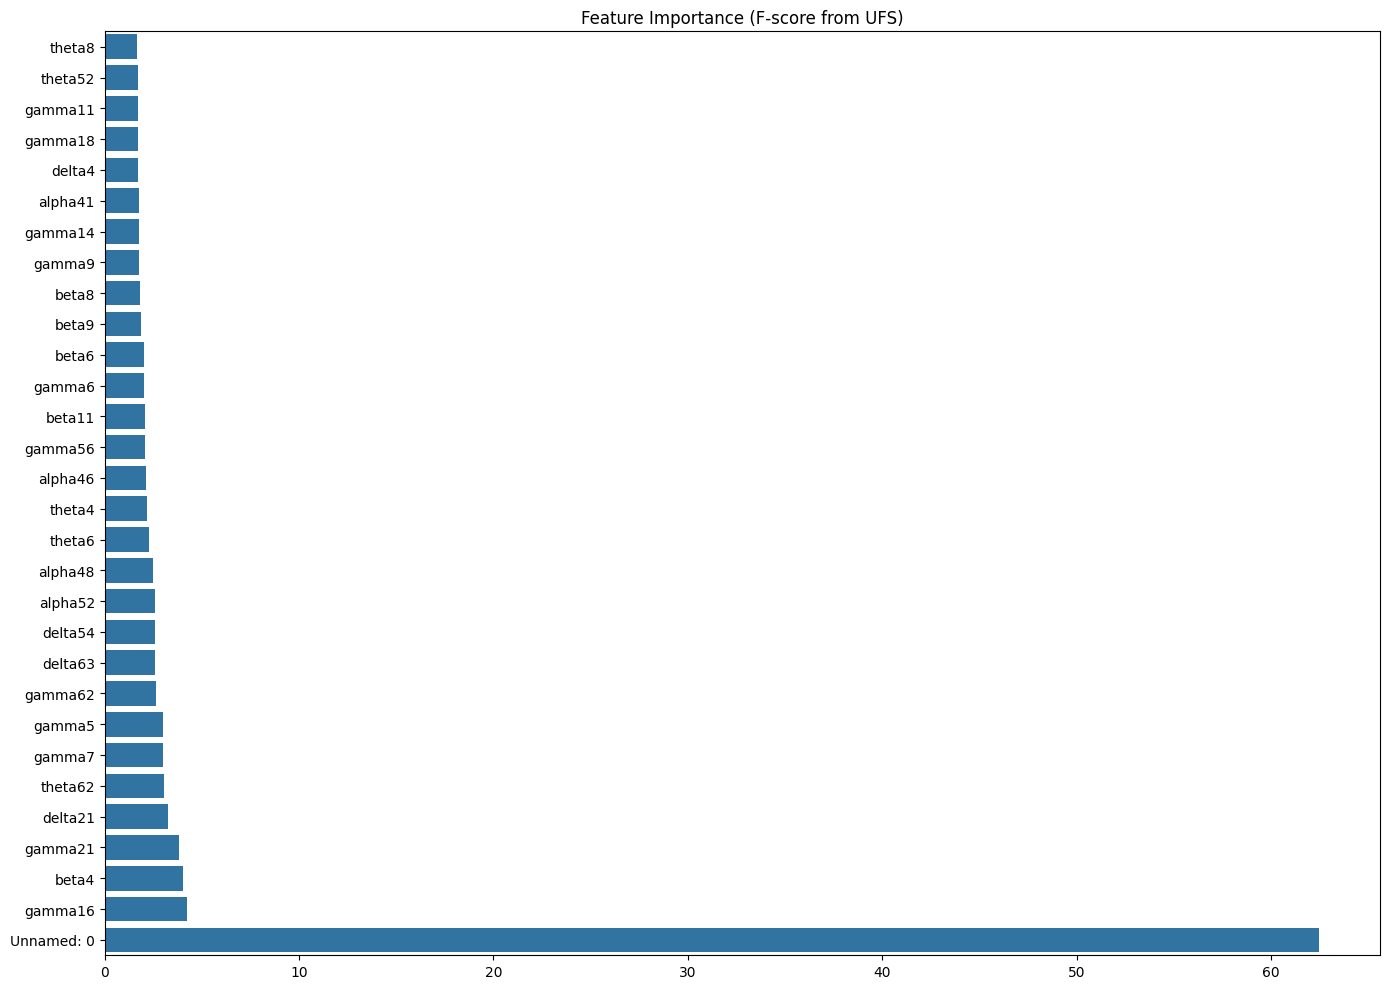

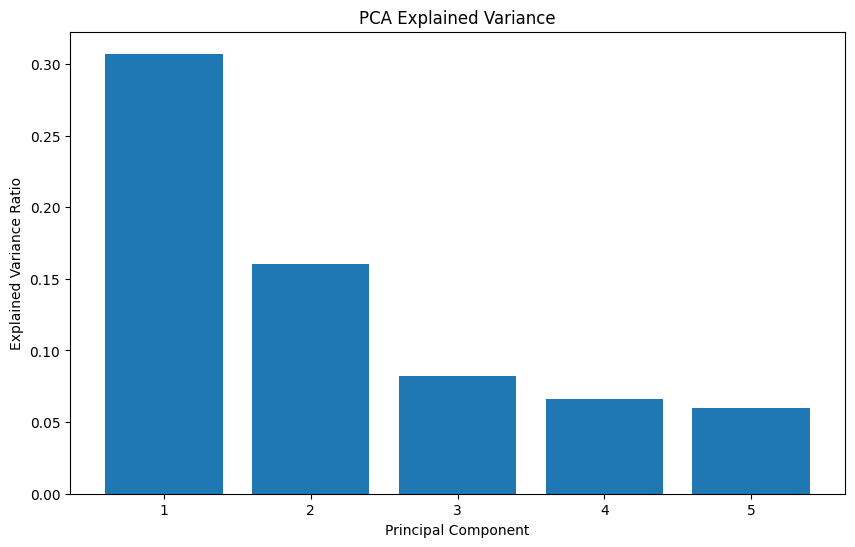

Analyzing spatial patterns in EEG data...
Feature names don't contain enough channel information for spatial analysis

=== Training and evaluating models with UFS feature selection ===
Training Linear Regression for classification...
Linear Regression - Best threshold: 0.4401587345371549, Validation accuracy: 1.0000
Training SVM with hyperparameter tuning...
SVM - Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Training KNN with hyperparameter tuning...
KNN - Best parameters: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}

Evaluating LR model:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
AUC-ROC: 1.0000

Evaluating SVM model:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
AUC-ROC: 1.0000

Evaluating KNN model:
Accuracy: 0.7500
Precision: 0.7500
Recall: 0.7500
F1 Score: 0.7500
AUC-ROC: 0.8750


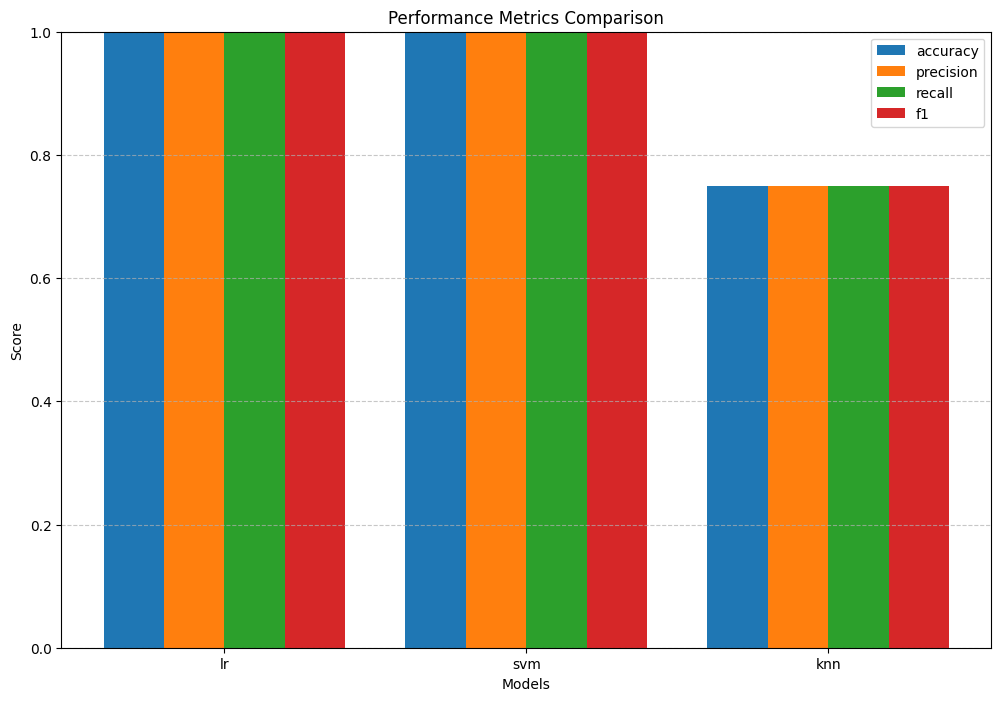

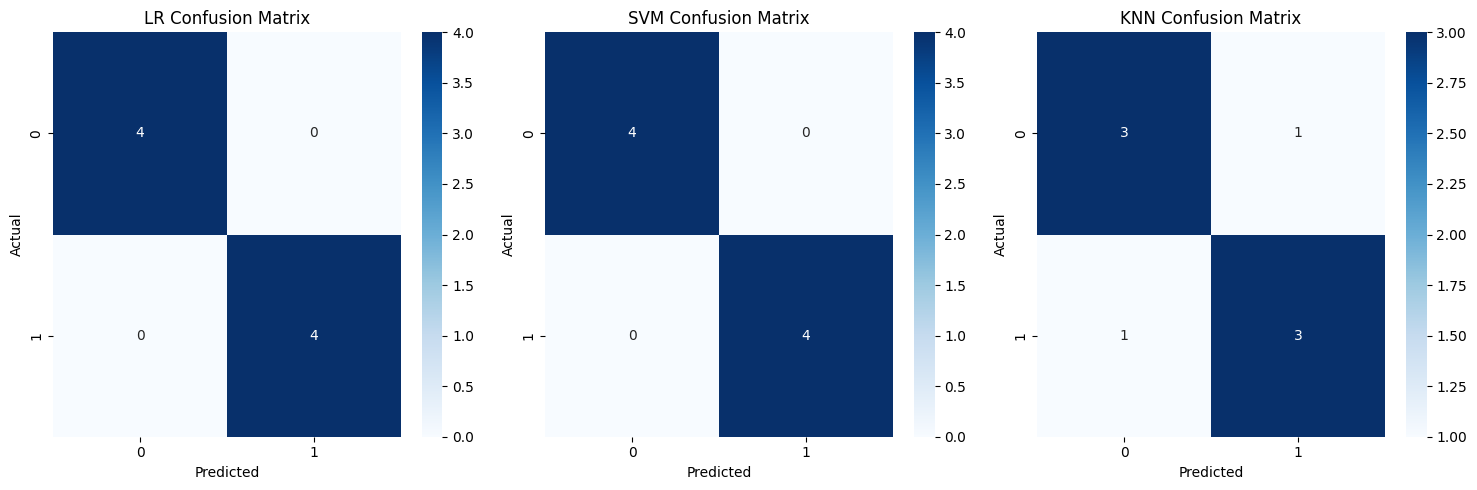

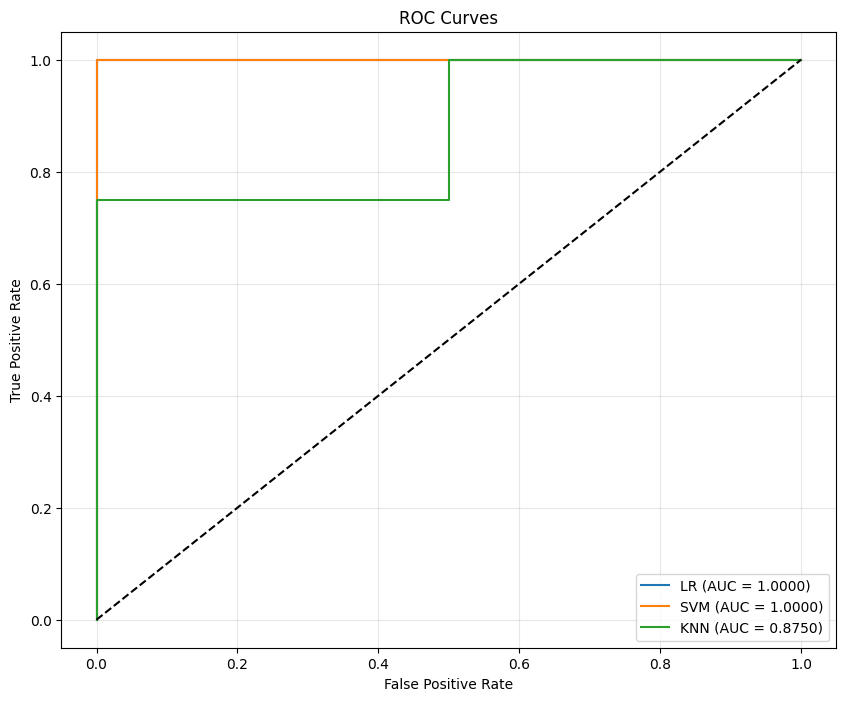


Interpreting models with SHAP values...

SHAP analysis for LR:


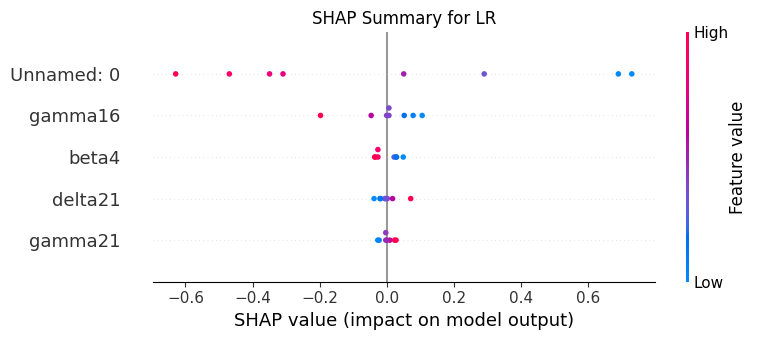

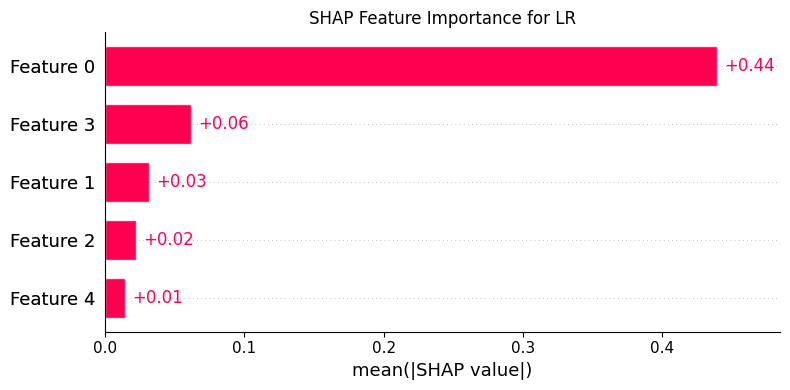


SHAP analysis for SVM:


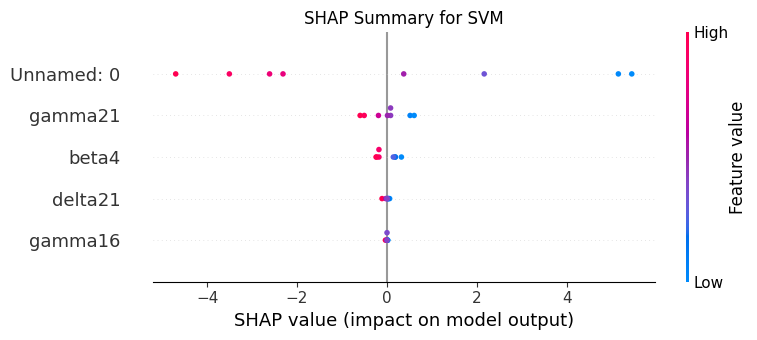

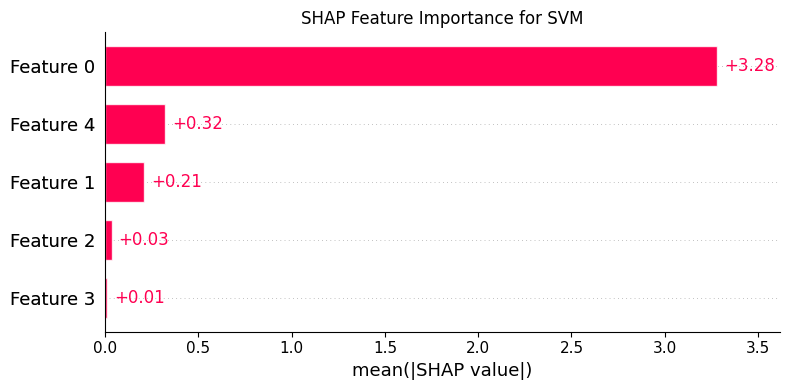


SHAP analysis for KNN:
Error in SHAP analysis for knn: The passed model is not callable and cannot be analyzed directly with the given masker! Model: KNeighborsClassifier(metric='euclidean', n_neighbors=3, weights='distance')
Falling back to permutation importance...


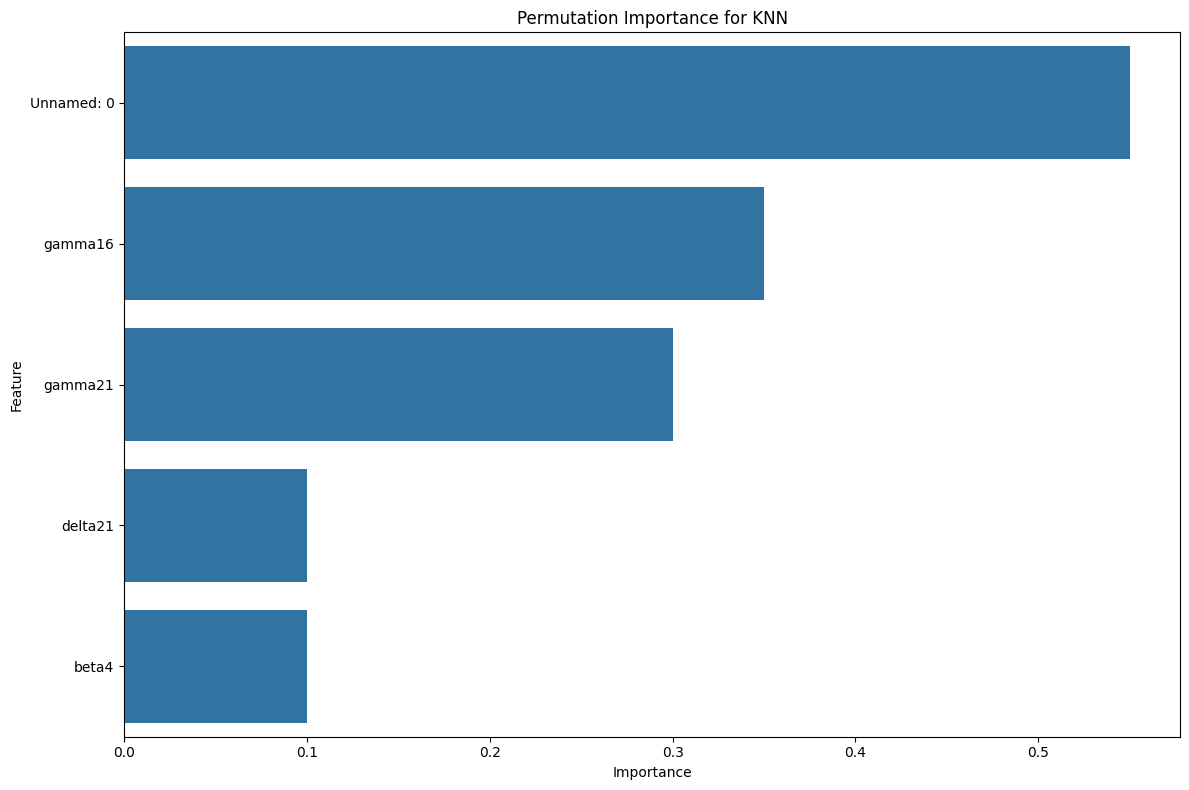


=== Training and evaluating models with RFE feature selection ===
Training Linear Regression for classification...
Linear Regression - Best threshold: 0.558064037078039, Validation accuracy: 1.0000
Training SVM with hyperparameter tuning...
SVM - Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Training KNN with hyperparameter tuning...
KNN - Best parameters: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}

Evaluating LR model:
Accuracy: 0.7500
Precision: 0.7500
Recall: 0.7500
F1 Score: 0.7500
AUC-ROC: 0.9375

Evaluating SVM model:
Accuracy: 0.7500
Precision: 0.8333
Recall: 0.7500
F1 Score: 0.7333
AUC-ROC: 0.8125

Evaluating KNN model:
Accuracy: 0.6250
Precision: 0.6333
Recall: 0.6250
F1 Score: 0.6190
AUC-ROC: 0.5625


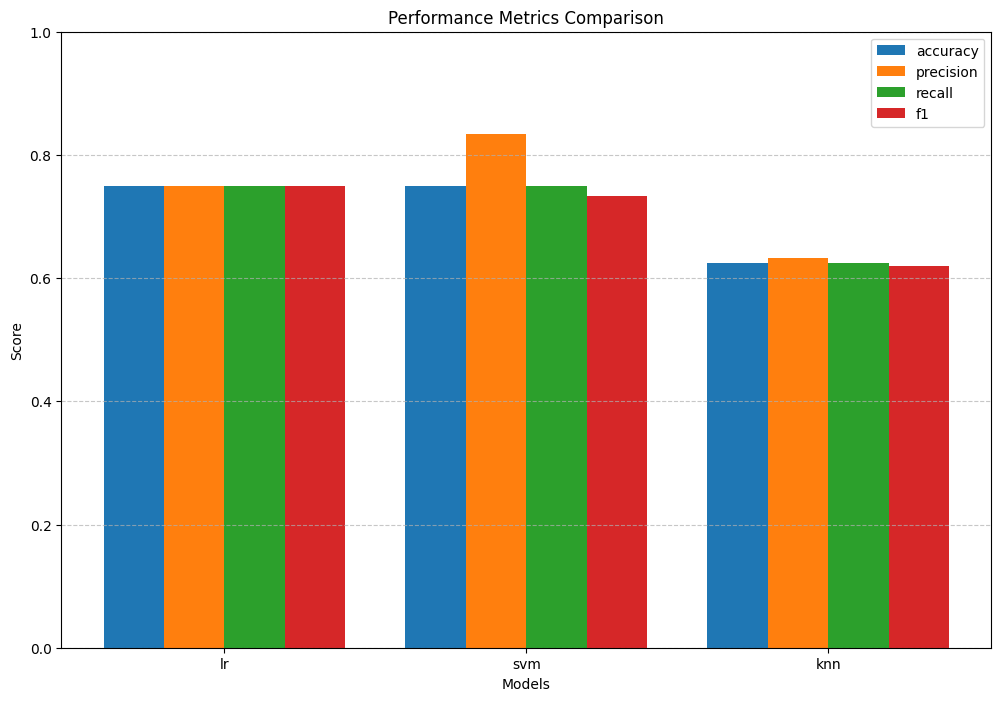

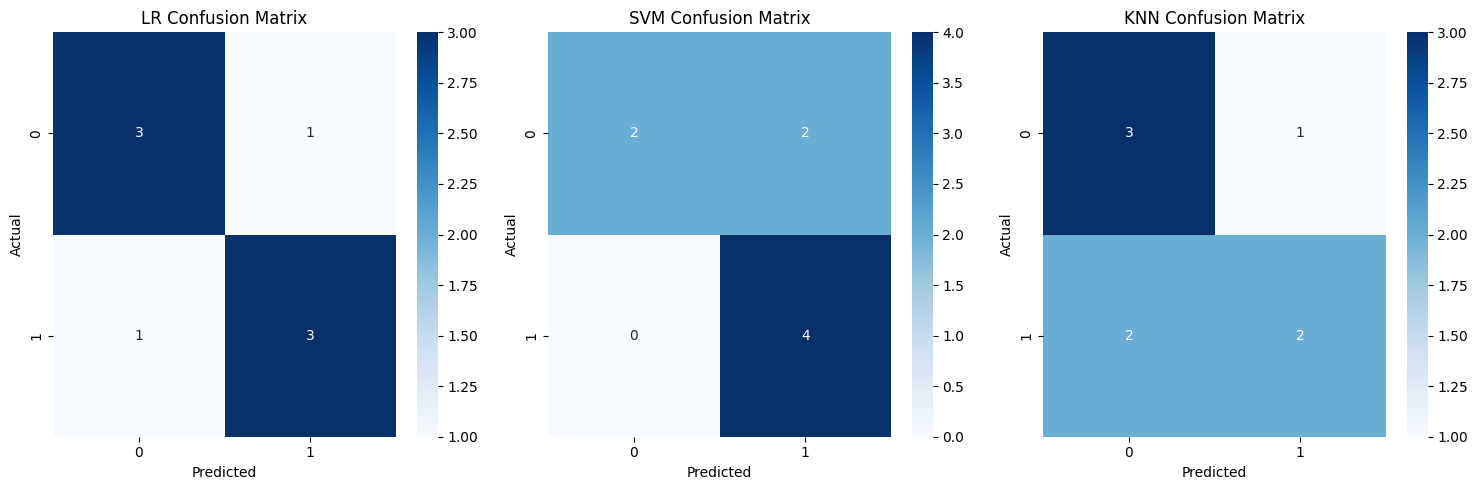

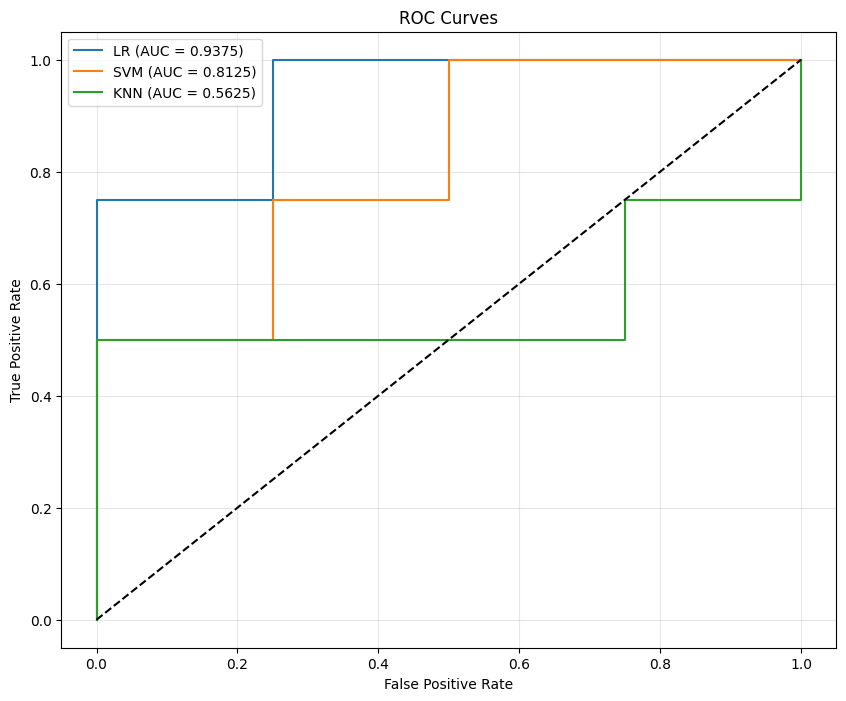


Interpreting models with SHAP values...

SHAP analysis for LR:


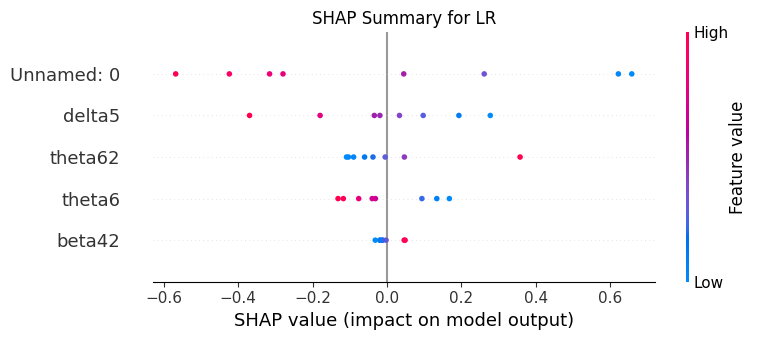

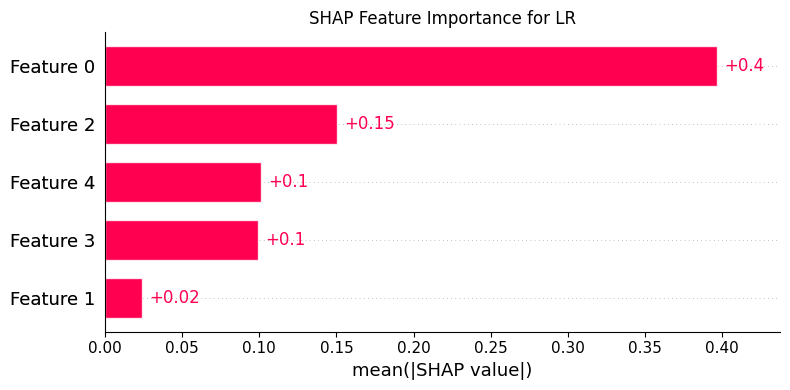


SHAP analysis for SVM:


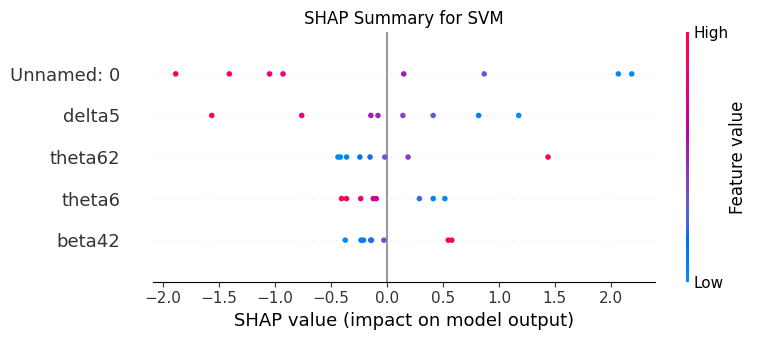

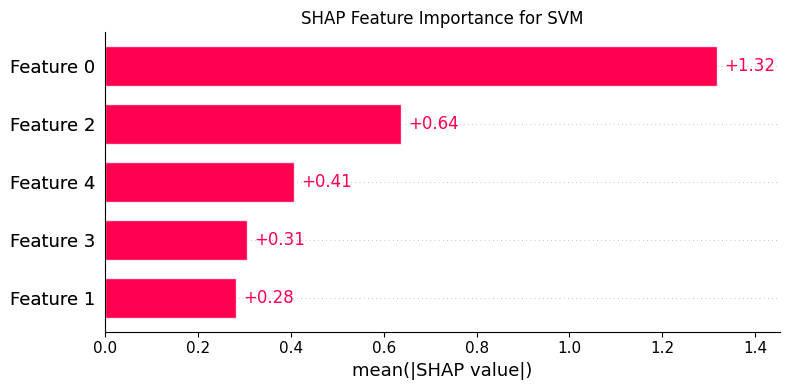


SHAP analysis for KNN:
Error in SHAP analysis for knn: The passed model is not callable and cannot be analyzed directly with the given masker! Model: KNeighborsClassifier(metric='euclidean', n_neighbors=7, weights='distance')
Falling back to permutation importance...


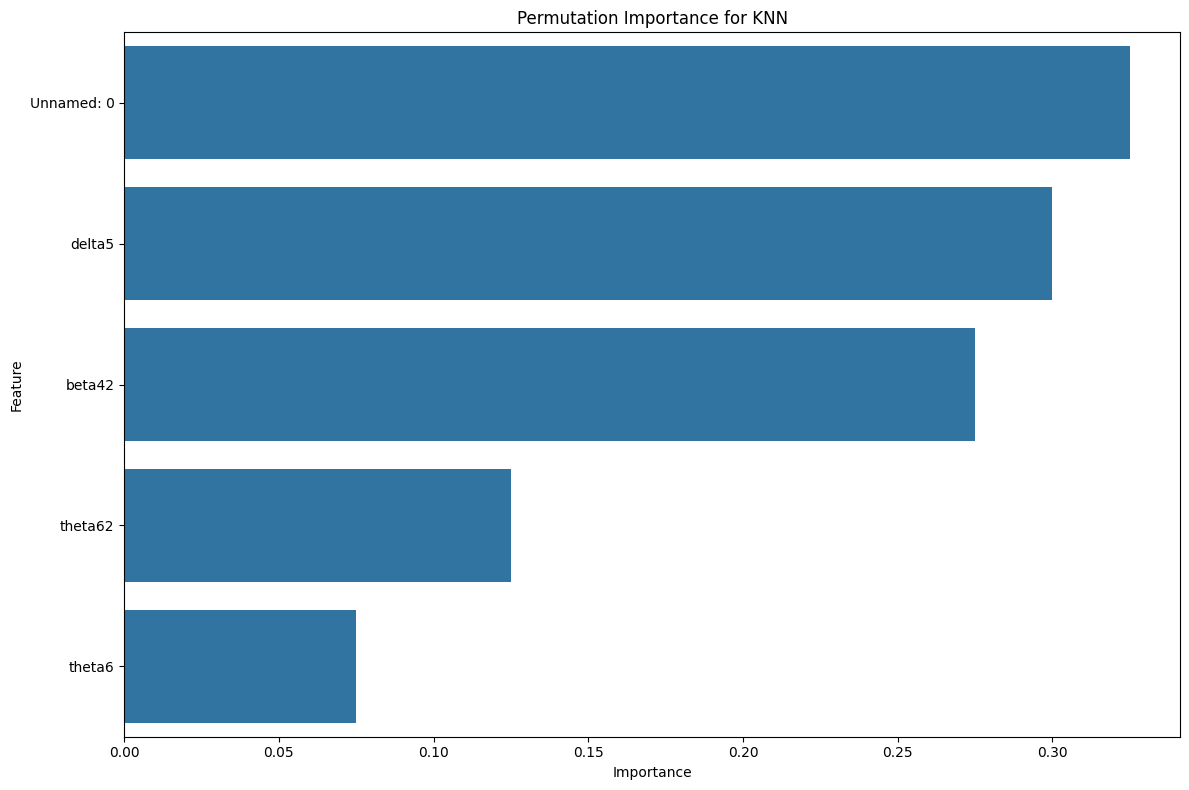


=== Training and evaluating models with PCA feature selection ===
Training Linear Regression for classification...
Linear Regression - Best threshold: 0.49214206511488456, Validation accuracy: 0.5000
Training SVM with hyperparameter tuning...
SVM - Best parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Training KNN with hyperparameter tuning...
KNN - Best parameters: {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'uniform'}

Evaluating LR model:
Accuracy: 0.2500
Precision: 0.1667
Recall: 0.2500
F1 Score: 0.2000
AUC-ROC: 0.3125

Evaluating SVM model:
Accuracy: 0.3750
Precision: 0.3667
Recall: 0.3750
F1 Score: 0.3651
AUC-ROC: 0.8125

Evaluating KNN model:
Accuracy: 0.2500
Precision: 0.2500
Recall: 0.2500
F1 Score: 0.2500
AUC-ROC: 0.2188


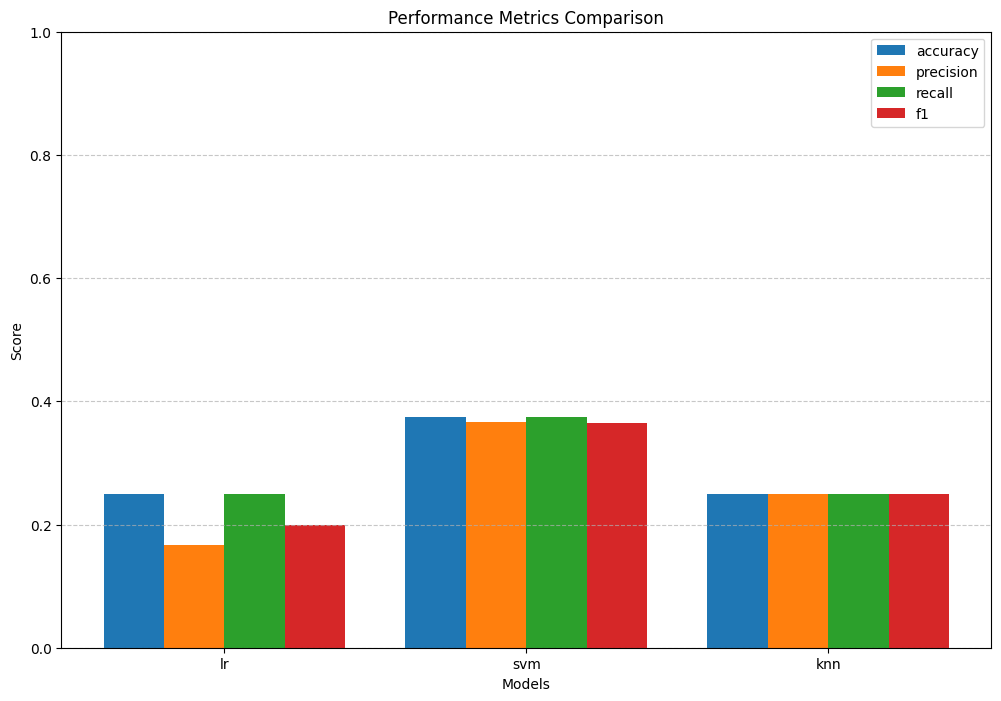

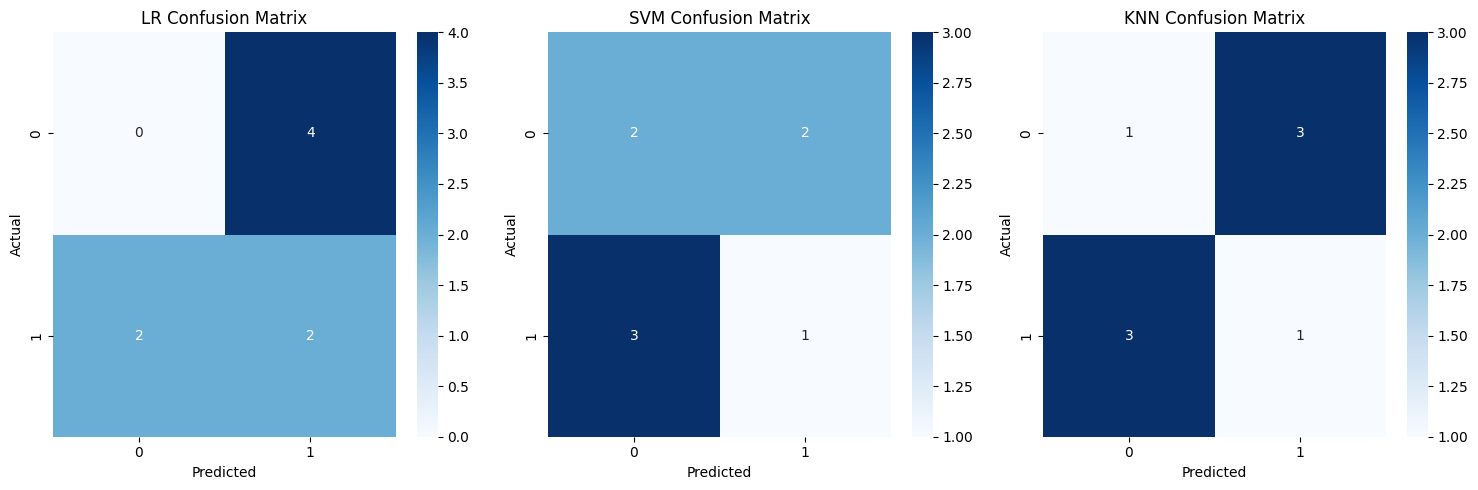

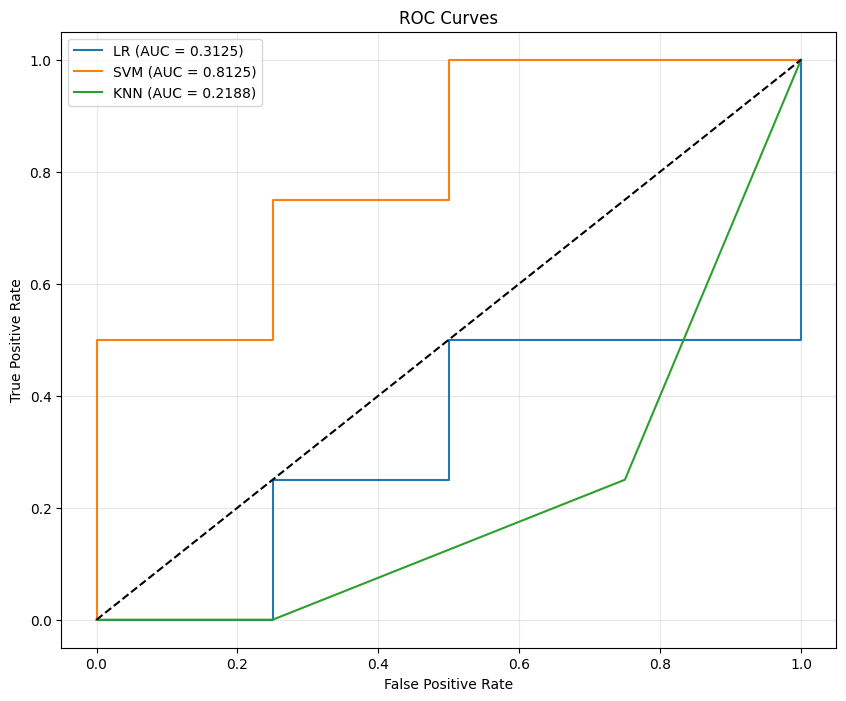


Interpreting models with SHAP values...

SHAP analysis for LR:


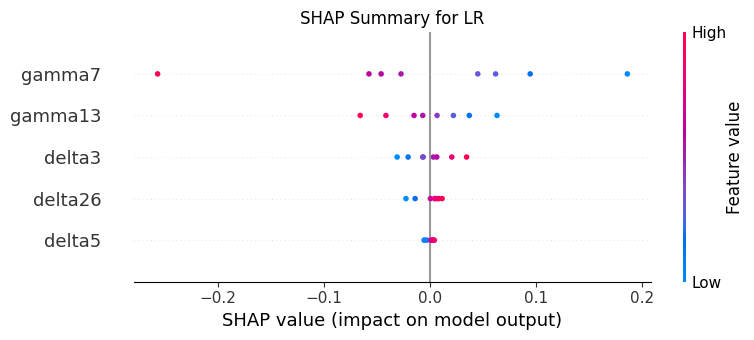

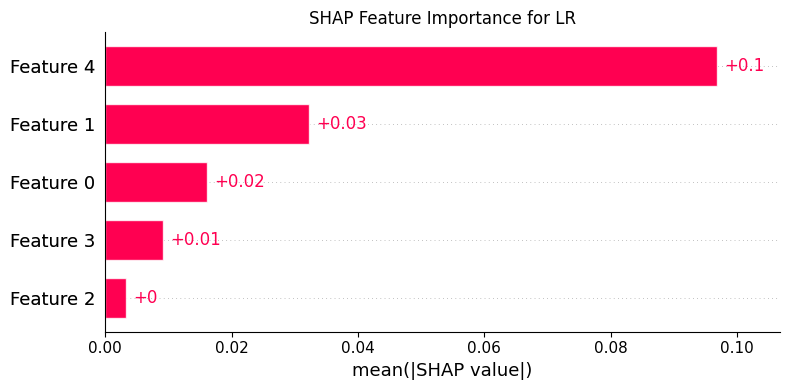


SHAP analysis for SVM:


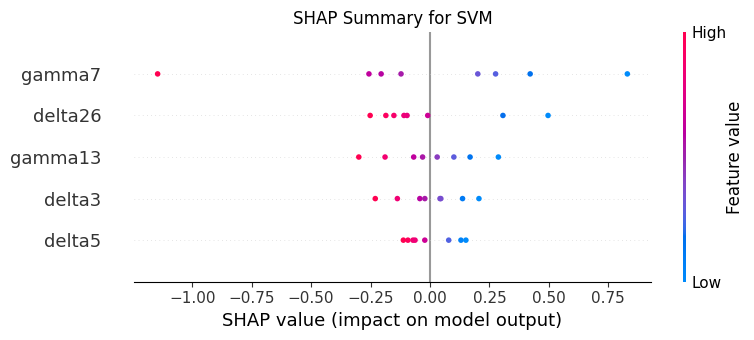

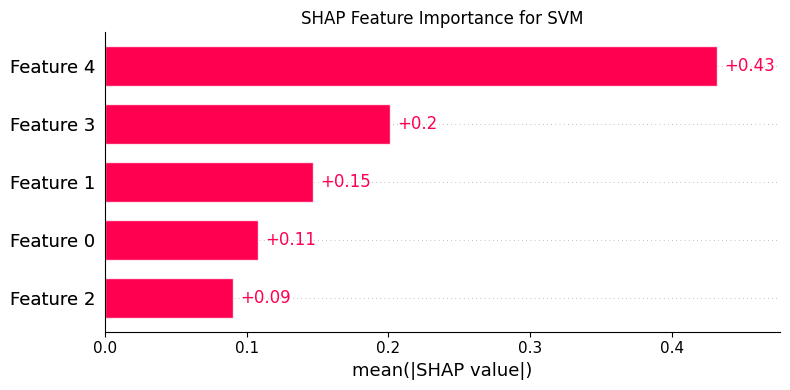


SHAP analysis for KNN:
Error in SHAP analysis for knn: The passed model is not callable and cannot be analyzed directly with the given masker! Model: KNeighborsClassifier(metric='euclidean', n_neighbors=11)
Falling back to permutation importance...


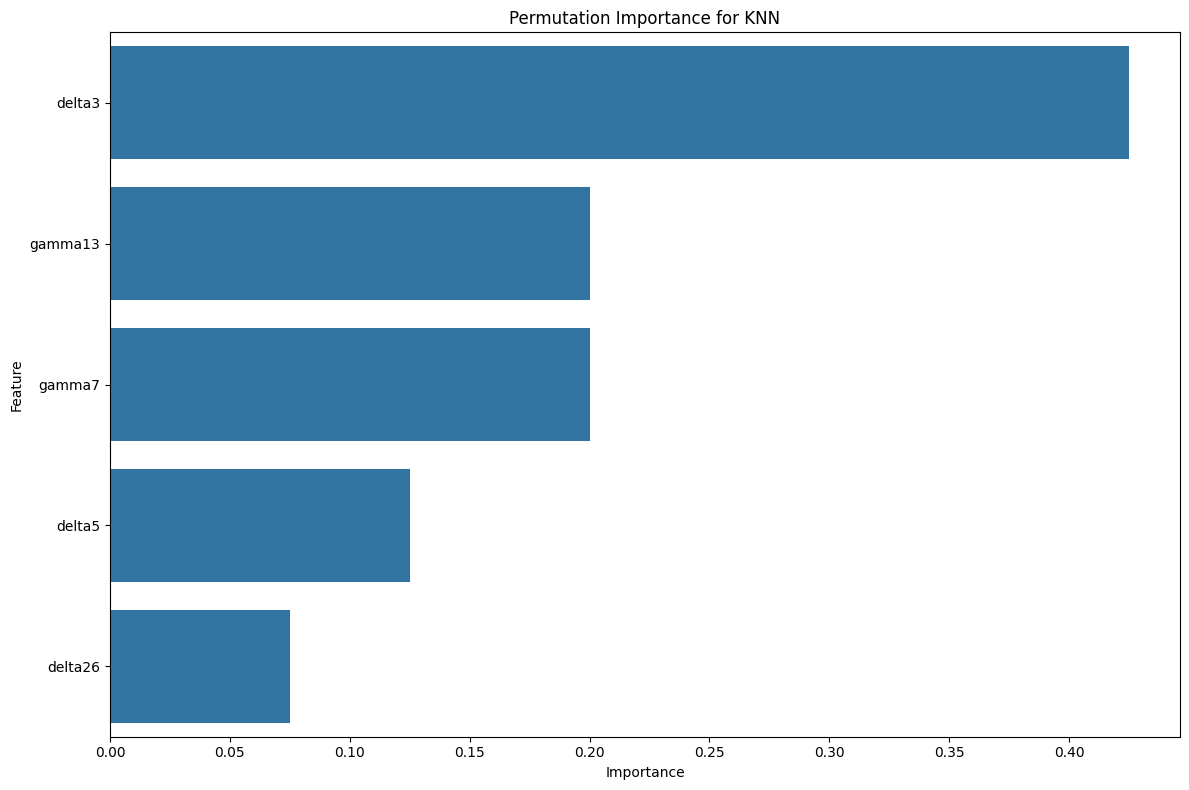


=== Comparison of Feature Selection Methods ===

Performance comparison table:
  Method Model  accuracy  precision  recall        f1
0    UFS    LR     1.000   1.000000   1.000  1.000000
1    UFS   SVM     1.000   1.000000   1.000  1.000000
2    UFS   KNN     0.750   0.750000   0.750  0.750000
3    RFE    LR     0.750   0.750000   0.750  0.750000
4    RFE   SVM     0.750   0.833333   0.750  0.733333
5    RFE   KNN     0.625   0.633333   0.625  0.619048
6    PCA    LR     0.250   0.166667   0.250  0.200000
7    PCA   SVM     0.375   0.366667   0.375  0.365079
8    PCA   KNN     0.250   0.250000   0.250  0.250000


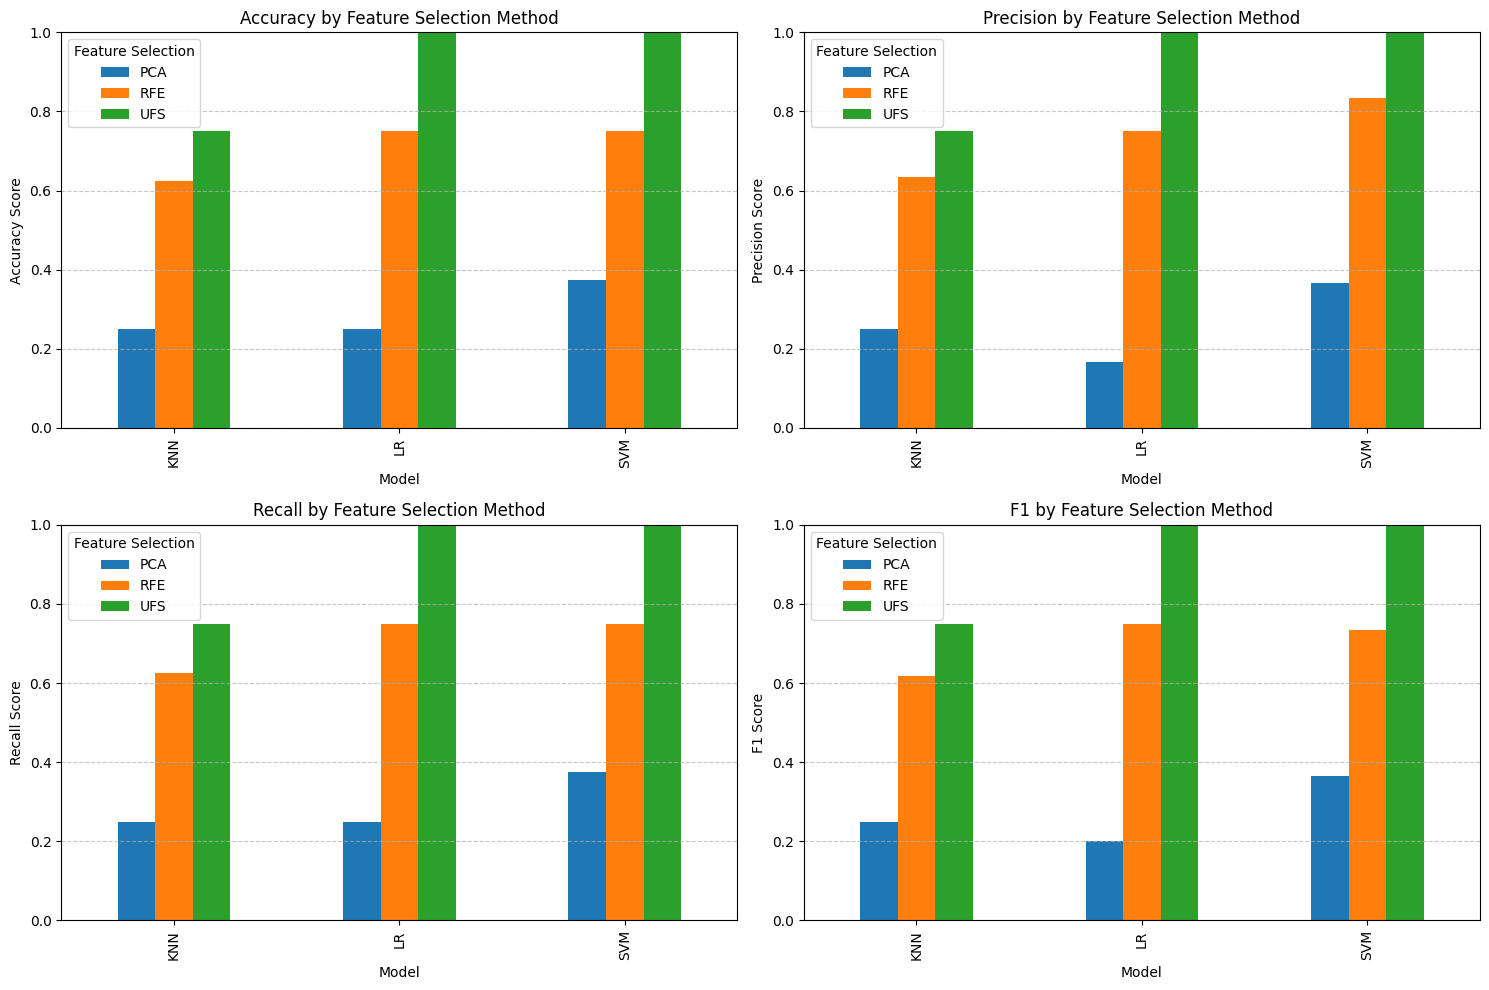


=== Top 5 Features by Selection Method ===

Top 5 UFS Features:
1. Unnamed: 0
2. beta4
3. delta21
4. gamma16
5. gamma21

Top 5 RFE Features:
1. Unnamed: 0
2. beta42
3. delta5
4. theta6
5. theta62

Top 5 PCA Features:
1. delta3
2. gamma13
3. delta5
4. delta26
5. gamma7


In [83]:
if __name__ == "__main__":
    main()